In [1]:
import keras
import numpy as np
import random
import matplotlib.pyplot as plt

GAMMA = 0.99
MEMORY_SIZE = 50000
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.98
MAX_NUMBER_OF_EPISODES_FOR_TRAINING = 600
NUMBER_OF_EPISODES_FOR_TESTING = 30
GOAL_SCORE = 200
NUMBER_OF_EPISODES_FOR_TESTING_GOAL_SCORE = 30
LEARN_BATCH = 4

class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size % MEMORY_SIZE
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]
        terminal_states = self.terminal_states[batch]
        return states, actions, rewards, states_next, terminal_states
        
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)

        # Neural model
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(20, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(90, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(90, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

        # Neural model target
        self.model_target = keras.models.Sequential()
        self.model_target.add(keras.layers.Dense(20, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
        self.model_target.add(keras.layers.Dense(90, activation="relu",kernel_initializer="he_normal"))
        self.model_target.add(keras.layers.Dense(90, activation="relu",kernel_initializer="he_normal"))
        self.model_target.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.model_target.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

        # self.model_target.set_weights(self.model.get_weights)

    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        # state = np.reshape(state, [1, self.number_of_observations])
        # next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state, exploration_rate):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            # state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def select_greedy_policy(self, state):
        # Generate an action for a given state using greedy policy
        # state = np.reshape(state, [1, self.number_of_observations])
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def learn(self, learn : bool):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model_target(states).numpy()
        q_next_states = self.model_target(next_states).numpy()

        for i in range(BATCH_SIZE):
            if (terminal_states[i]):
                q_targets[i][actions[i]] = rewards[i]
            else:
                q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])

        self.model.train_on_batch(states, q_targets)

        if learn:
          # print("Weights has been updated")
            weights = self.model.get_weights()
            self.model_target.set_weights(weights)

In [2]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import keras
import numpy as np
import random
import matplotlib.pyplot as plt

# import zmqRemoteApi

GAMMA = 0.95
MEMORY_SIZE = 50000
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.99
MAX_NUMBER_OF_EPISODES_FOR_TRAINING = 600
NUMBER_OF_EPISODES_FOR_TESTING = 30
GOAL_SCORE = 200
NUMBER_OF_EPISODES_FOR_TESTING_GOAL_SCORE = 30
LEARN_BATCH = 4

class Coppelia():

    def __init__(self):
        client = RemoteAPIClient()
        self.sim = client.getObject('sim')
        
    def start_simulation(self):
        self.default_idle_fps = self.sim.getInt32Param(self.sim.intparam_idle_fps)
        self.sim.setInt32Param(self.sim.intparam_idle_fps, 0)
        self.sim.startSimulation()

    def stop_simulation(self):
        self.sim.stopSimulation()
        while self.sim.getSimulationState() != self.sim.simulation_stopped:
            time.sleep(0.1)
        self.sim.setInt32Param(self.sim.intparam_idle_fps, self.default_idle_fps)

    def is_running(self):
        return self.sim.getSimulationState() != self.sim.simulation_stopped
    
class State():
    def __init__(self):
        self.left_wall_metric = 0
        self.right_metric = 0
        self.left_metric = 0
        self.forward_metric = 0
        self.backward_metric = 0
        self.wandering = 0
        self.left_wall = 0
        self.front_wall = 0
    
    def list_state(self):
        return np.array([[self.left_wall_metric, self.right_metric, self.left_metric, 
                         self.forward_metric, self.wandering, self.left_wall, self.front_wall]] )

class P3DX():
    num_sonar = 16
    sonar_max = 1.0

    def __init__(self, sim, robot_id) -> None:
        self.sim = sim
        self.left_motor = self.sim.getObject(f'/{robot_id}/leftMotor')
        self.right_motor = self.sim.getObject(f'/{robot_id}/rightMotor')
        self.sonar = [self.sim.getObject(f'/{robot_id}/visible/ultrasonicSensor[{idx}]') for idx in range(self.num_sonar)]
        self.learning_network = DQN(7, 5)
        self.state = None
        self.readings = self.get_sonar()
        
    def get_sonar(self):
        readings = []
        for i in range(self.num_sonar):
            res, dist, _, _, _ = self.sim.readProximitySensor(self.sonar[i])
            readings.append(dist if res == 1 else self.sonar_max)
        return readings

    def get_action(self, exploration_rate, test: bool = False):
        if not test:
            return self.learning_network.select(self.state.list_state(), exploration_rate)
        else:
            return self.learning_network.select_greedy_policy(self.state.list_state())

    def set_speed(self, action):
        if action == 0:
            ispeed, rspeed = self.turn_right(0)
        if action == 1:
            ispeed, rspeed = self.turn_right(0.25)
        if action == 2:
            ispeed, rspeed = self.move_forward()
        if action == 3:
            ispeed, rspeed = self.turn_left(0.25)
        if action == 4:
            ispeed, rspeed = self.turn_left(0)
        self.sim.setJointTargetVelocity(self.left_motor, ispeed)
        self.sim.setJointTargetVelocity(self.right_motor, rspeed)

    def move_forward(self):
        ispeed, rspeed = 1, 1
        return ispeed, rspeed
    
    def move_backward(self):
        ispeed, rspeed = -1, -1
        return ispeed, rspeed

    def turn_right(self, grade):
        ispeed, rspeed = 1, grade
        return ispeed, rspeed

    def turn_left(self, grade):
        ispeed, rspeed = grade, 1
        return ispeed, rspeed

    def get_metrics(self, readings):
        metrics = {}
        metrics["forward_metrics"] = readings[3] * readings[4]
        metrics["left_metrics"] = readings[1] * readings[2]
        metrics["right_metrics"] = readings[5] * readings[6]
        metrics["left_wall_metrics"] = readings[0]
        metrics["readings"] = readings
        return metrics

    def set_state(self):
        readings = self.get_sonar()
        metrics = self.get_metrics(readings)
        self.state.right_metric = metrics["right_metrics"]
        self.state.left_metric = metrics["left_metrics"]
        self.state.forward_metric = metrics["forward_metrics"]
        self.state.left_wall_metric = metrics["left_wall_metrics"]
        if metrics["forward_metrics"] < 0.9:
            self.state.wandering = 0
            self.state.front_wall = 1
        if metrics["left_wall_metrics"] < 0.9:
            self.state.wandering = 0
            self.state.left_wall = 1
        if self.state.left_wall == 0 and self.state.front_wall == 0:
            self.state.wandering = 1
        else:
            self.state.wandering += 0.25
            self.state.left_wall -= 0.25
            self.state.front_wall -= 0.25
        return self.state

class environment():
    def __init__(self, robot_id, sim):
        self.actions = [0, 1, 2, 3, 4] # 0: left, 1: fordward-left, 2:fordward , 3: fordward-right, 4: right
        self.number_of_observations = 7 # fordward-metrics, left-metrics, right-metrics, right-wall-metrics, left-wall-metrics, wandering, front-wall, right-wall, left-wall
        self.number_of_actions = 5
        self.robot = P3DX(sim, robot_id)

    def reward(self, multiplier, action):
        reward = 0
        # turn right
        if action == 0:
            if self.robot.state.wandering > 0.75:
                reward = -7.5 * multiplier
            else:
                if self.robot.state.front_wall > 0:
                    reward = 25
                elif self.robot.state.left_wall > 0:
                    reward = -50
                else:
                    reward = 1
        # fordward-turn right
        if action == 1:
            if self.robot.state.wandering > 0.75:
                reward =  -5 * multiplier
            else:
                if self.robot.state.front_wall > 0:
                    reward = -10
                elif self.robot.state.left_wall > 0:
                    if self.robot.state.left_metric < 0.4:
                        reward = 15
                    else:
                        reward = -5
                else:
                    reward = -5
        # fordward
        if action == 2:
            if self.robot.state.wandering > 0.75:
                reward =  -3 * multiplier
            else:
                if self.robot.state.front_wall > 0:
                    reward = -100
                elif self.robot.state.left_wall > 0:
                    if self.robot.state.left_metric < 0.2:
                        reward = -5
                    elif self.robot.state.left_metric < 0.6 and self.robot.state.left_metric > 0.4:
                        reward = 30
                    else:
                        reward = -15
                else:
                    reward = -1
        # fordward-turn left
        if action == 3:
            if self.robot.state.wandering > 0.75:
                reward =  -5 * multiplier
            else:
                if self.robot.state.front_wall > 0:
                    reward = -50
                elif self.robot.state.right_metric < 0.2:
                    reward = 20    
                elif self.robot.state.left_metric > 0.6 and self.robot.state.left_metric < 0.9:
                        reward = 20
                elif self.robot.state.left_wall_metric > 0.6 and self.robot.state.left_wall_metric < 0.9:
                        reward = 20
                else:
                    reward = -5
        # turn left
        if action == 4:
            if self.robot.state.wandering > 0.75:
                reward = -7.5 * multiplier
            else:
                if self.robot.state.front_wall > 0:
                    reward = -50
                else:
                    if self.robot.state.left_wall < 0.75 and self.robot.state.left_wall > 0:
                        reward = 25
                    else:
                        reward = -5
        return reward 
    

[[0.21542175 0.59223715 0.04872756 0.2711621 0.25 0.75 0.75]]

In [3]:
def writte_log(state, action, reward, score, episode, step):
    with open("log.csv", "a") as file:
        file.write(f"State: {state}, Action: {action}, Reward: {reward}, Score: {score}, Episode: {episode}, Step: {step}\n")

def writte_log_test(state, action, reward, score, episode, step):
    with open("log_test.csv", "a") as file:
        file.write(f"State: {state}, Action: {action}, Reward: {reward}, Score: {score}, Episode: {episode}, Step: {step}\n")

In [4]:
coppelia = Coppelia()
env = environment(robot_id= "PioneerP3DX", sim=coppelia.sim)
robot = env.robot
robot.state = State()

In [5]:

coppelia.start_simulation()

episode = 0
# start_time = time.perf_counter()
total_steps = 1
exploration_rate = EXPLORATION_MAX
goal_reached = False
learn_batch = 0
while (episode < 1) and coppelia.is_running():
    episode += 1
    steps = 1
    score = 0
    state = robot.set_state().list_state()
    count_action = 1
    last_action = None
    end_episode = False
    while steps < 6000:
        learn_batch +=1
        # Select an action for the current state
        action = robot.get_action(exploration_rate, test=False)
        if action == last_action:
            count_action += 0.25
        else:
            count_action = 1
       # Execute the action on the environment
        reward = env.reward(count_action, action)

        print(reward, state, action)
        # if state[0, 5] == 1 and action == 2:
        #     reward += 250
        robot.set_speed(action)
        state_next = robot.set_state().list_state()
        print(state, steps, action)

        # Store in memory the transition (s,a,r,s')
        robot.learning_network.remember(state, action, reward, state_next, False)

        score += reward

        # Learn using a batch of experience stored in memory
        if learn_batch == LEARN_BATCH:
            robot.learning_network.learn(True)
            learn_batch = 0
        else:
            robot.learning_network.learn(False)

        state = state_next
        last_action = action
        total_steps += 1
        steps += 1

        writte_log(state, action, reward, score, episode, steps)

    # Decrease exploration rate
        exploration_rate *= EXPLORATION_DECAY
        exploration_rate = max(EXPLORATION_MIN, exploration_rate)
        
coppelia.stop_simulation()

-5 [[1. 1. 1. 1. 1. 0. 0.]] 3
[[1. 1. 1. 1. 1. 0. 0.]] 1 3
-5 [[ 0.33675934  1.          0.38974436  1.          0.25        0.75
  -0.25      ]] 3
[[ 0.33675934  1.          0.38974436  1.          0.25        0.75
  -0.25      ]] 2 3
-50 [[ 0.33507747  1.          0.20448913  1.          0.25        0.75
  -0.5       ]] 0
[[ 0.33507747  1.          0.20448913  1.          0.25        0.75
  -0.5       ]] 3 0
-5 [[ 0.33131807  1.          0.18460514  1.          0.25        0.75
  -0.75      ]] 2
[[ 0.33131807  1.          0.18460514  1.          0.25        0.75
  -0.75      ]] 4 2
15 [[ 0.33139345  1.          0.19312193  1.          0.25        0.75
  -1.        ]] 1
[[ 0.33139345  1.          0.19312193  1.          0.25        0.75
  -1.        ]] 5 1
-50 [[ 0.33138599  1.          0.19566155  1.          0.25        0.75
  -1.25      ]] 0
[[ 0.33138599  1.          0.19566155  1.          0.25        0.75
  -1.25      ]] 6 0
-50 [[ 0.33203665  1.          0.20180806  1.         

KeyboardInterrupt: 

TEST

In [128]:
coppelia.start_simulation()

score = 0
episode = 0
# start_time = time.perf_counter()
total_steps = 1
goal_reached = False
while (episode < 2) and coppelia.is_running():
    episode += 1
    steps = 1
    score = 0
    state = robot.set_state().list_state()
    count_action = 1
    last_action = None
    end_episode = False
    while steps < 2000:
        learn_batch +=1
        # Select an action for the current state
        action = robot.get_action(exploration_rate, test=True)
        if action == last_action:
            count_action += 0.25
        else:
            count_action = 1
       # Execute the action on the environment
        reward = env.reward(count_action, action)
        print(reward, state, action)

        robot.set_speed(action)
        state_next = robot.set_state().list_state()
        print(state, steps, action)

        score += reward

        state = state_next
        last_action = action
        total_steps += 1
        steps += 1

        writte_log_test(state, action, reward, score, episode, steps)

coppelia.stop_simulation()

25 [[1.  1.  1.  1.  0.5 0.5 0.5]] 0
[[1.  1.  1.  1.  0.5 0.5 0.5]] 1 0
25 [[0.61413098 1.         0.71105553 1.         0.25       0.75
  0.25      ]] 0
[[0.61413098 1.         0.71105553 1.         0.25       0.75
  0.25      ]] 2 0
20 [[0.62128049 1.         0.76952944 1.         0.25       0.75
  0.        ]] 3
[[0.62128049 1.         0.76952944 1.         0.25       0.75
  0.        ]] 3 3
20 [[ 0.63026809  1.          0.82329373  1.          0.25        0.75
  -0.25      ]] 3
[[ 0.63026809  1.          0.82329373  1.          0.25        0.75
  -0.25      ]] 4 3
20 [[ 0.63023775  1.          0.79731404  1.          0.25        0.75
  -0.5       ]] 3
[[ 0.63023775  1.          0.79731404  1.          0.25        0.75
  -0.5       ]] 5 3
20 [[ 0.62833937  1.          0.76073297  1.          0.25        0.75
  -0.75      ]] 3
[[ 0.62833937  1.          0.76073297  1.          0.25        0.75
  -0.75      ]] 6 3
20 [[ 0.62482519  1.          0.72848667  1.          0.25        0.75

25 [[0.59278544 1.         0.36705544 0.8385053  0.25       0.75
  0.75      ]] 0
[[0.59278544 1.         0.36705544 0.8385053  0.25       0.75
  0.75      ]] 15 0
25 [[0.59345635 1.         0.33603321 0.76722993 0.25       0.75
  0.75      ]] 0
[[0.59345635 1.         0.33603321 0.76722993 0.25       0.75
  0.75      ]] 16 0
25 [[0.57922187 1.         0.34348382 0.81774387 0.25       0.75
  0.75      ]] 0
[[0.57922187 1.         0.34348382 0.81774387 0.25       0.75
  0.75      ]] 17 0
25 [[0.56904414 1.         0.56067654 1.         0.25       0.75
  0.5       ]] 0
[[0.56904414 1.         0.56067654 1.         0.25       0.75
  0.5       ]] 18 0
25 [[0.70867494 1.         0.60159955 1.         0.25       0.75
  0.25      ]] 0
[[0.70867494 1.         0.60159955 1.         0.25       0.75
  0.25      ]] 19 0
20 [[0.7066631  1.         0.64669203 1.         0.25       0.75
  0.        ]] 3
[[0.7066631  1.         0.64669203 1.         0.25       0.75
  0.        ]] 20 3
20 [[ 0.7072503 

KeyboardInterrupt: 

5999


<Axes: >

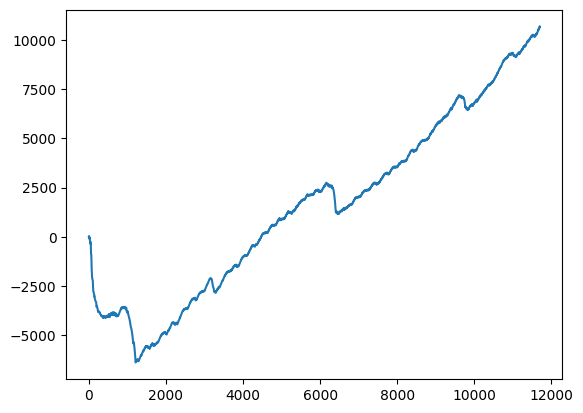

In [155]:
import pandas as pd

log = pd.read_csv("rewards_buenas.csv", sep=",")
score = log[" Score"].dropna()

score_values = score.map(lambda x: float(x.split(":")[1].strip()))

print(score_values.count())
score_values.plot()

1940


<Axes: >

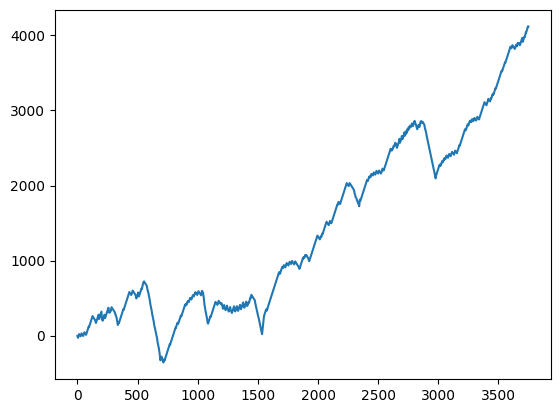

In [156]:
log = pd.read_csv("rewards_buenas_test.csv", sep=",")
score = log[" Score"].dropna()

score_values = score.map(lambda x: float(x.split(":")[1].strip()))

print(score_values.count())	
score_values.plot()